<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.isnull().sum()

num_orders    0
dtype: int64

В датасете имеется два столбца: 
- *datetime* - время и дата заказов;
- *num_orders* - количество заказов.

Для анализа собраны данные за полгода, с 1 марта по 31 августа 2018 года.

Пустых значений нет, перейдем к анализу.

## Анализ

Теперь проанализируем данные, для этого рассмотрим ресемплированные данные, тренды и сезонность.

Text(0.5, 1.0, 'Распределение заказов по месяцам')

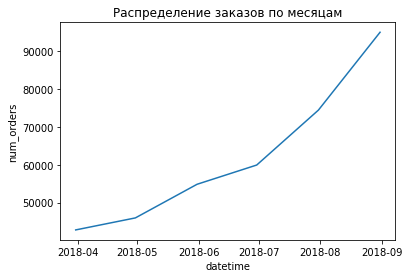

In [ ]:
month = data.resample('1M').sum()
sns.lineplot(x=month.index,y=month['num_orders']).set_title('Распределение заказов по месяцам')

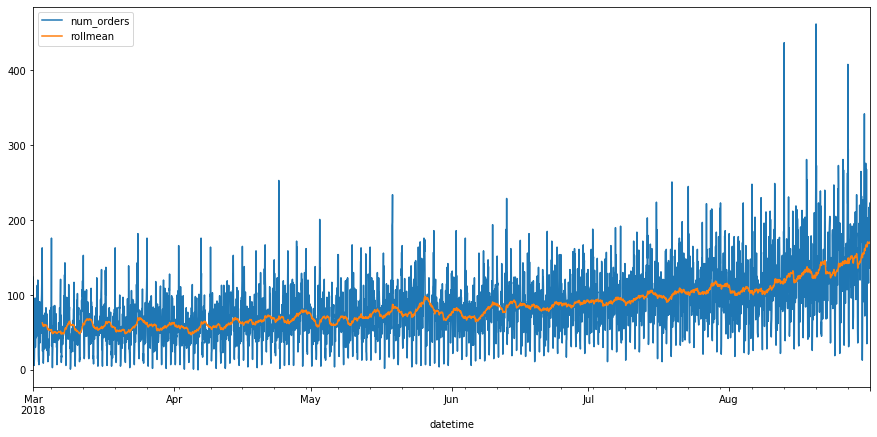

In [ ]:
hour = data.resample('1H').sum()
hour['rollmean']=hour['num_orders'].rolling(50).mean()
hour.plot(figsize=(15,7))

In [ ]:
data = data.resample('1H').sum()

In [ ]:
decomposed = seasonal_decompose(data)

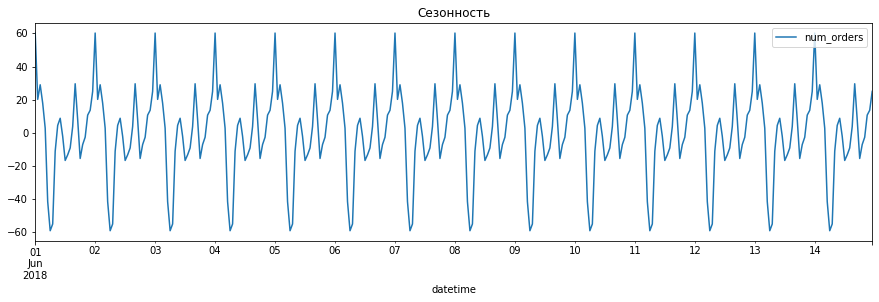

In [ ]:
decomposed.seasonal['2018-06-01':'2018-06-14'].plot(ax=plt.gca(), title='Сезонность', figsize=(15,4))

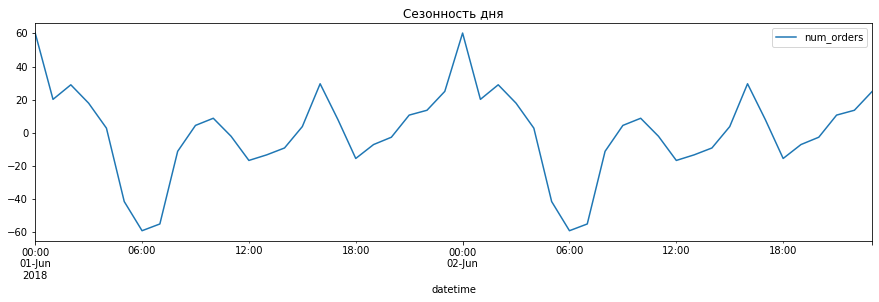

In [ ]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca(), title='Сезонность дня', figsize=(15,4))

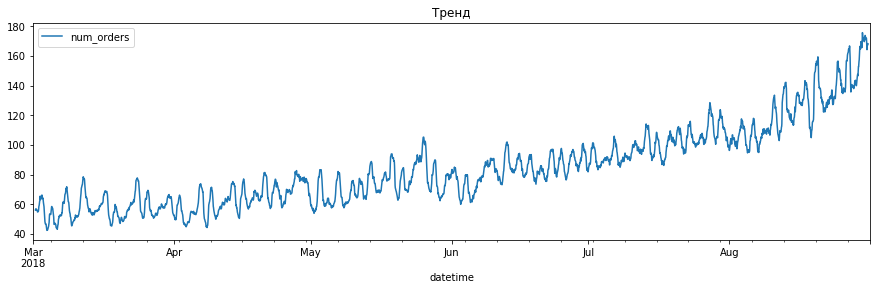

In [ ]:
decomposed.trend.plot(ax=plt.gca(), title='Тренд', figsize=(15,4))

В данном шаге были проанализированы заказы, рассмотрены сезонность и тренды. Из графиков можно сделать выводы:
- общее количество заказов растет с каждым месяцем;
- в течение дня количество заказов падает к утру, наименьшее количество можно наблюдать в 6 утра, а максимальное около 12 ночи.

## Обучение

Подготовим признаки и обучим модели.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [ ]:
rmse_ = 10**4
for lag in range(1, 50):
    for size in range(1,50):
        df = make_features(data, lag, size)
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()

        target_train_lr = train['num_orders']
        features_train_lr = train.drop(['num_orders'], axis=1)
        target_test_lr = test['num_orders']
        features_test_lr = test.drop(['num_orders'], axis=1)
        
        lr = LinearRegression()
        lr.fit(features_train_lr, target_train_lr)
        
        predictions_train_lr = lr.predict(features_train_lr)
        rmse = mean_squared_error(target_train_lr, predictions_train_lr)**0.5
        if rmse < rmse_:
            rmse_ = rmse
            best_lag = lag
            best_rolling_size = size
       
print('RMSE линейной регрессии на тренировочной выборке:', rmse_)
print('max_lag:', best_lag, 'rolling_mean_size:', best_rolling_size)

RMSE линейной регрессии на тренировочной выборке: 23.431441995032273
max_lag: 49 rolling_mean_size: 48


In [ ]:
#проверим модель LightGBM с такими же параметрами max_lag и rolling_mean_size
df = make_features(data, 49, 48)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

target_train_lgbm = train['num_orders']
features_train_lgbm = train.drop(['num_orders'], axis=1)
target_test_lgbm = test['num_orders']
features_test_lgbm = test.drop(['num_orders'], axis=1)

lgbm = LGBMRegressor()
lgbm.fit(features_train_lgbm, target_train_lgbm)

predictions_train_lgbm = lgbm.predict(features_train_lgbm)
rmse = mean_squared_error(target_train_lgbm, predictions_train_lgbm)**0.5
       
print('RMSE LightGBM модели на тренировочной выборке:', rmse)

RMSE LightGBM модели на тренировочной выборке: 10.778119365795629


В данном шаге были подготовлены признаки, а также обучены и проверены на тренировочной выборке две модели: LinearRegression и LGBMRegressor. Наилучший результат показала модель  LightGBM с полученным RMSE - 10.78, максимальным размером отставания - 49 и шириной окна - 48. Результаты модели линейной регрессии: RMSE - 23.4.

## Тестирование

Проверим модели на тестовой выборке.

In [ ]:
#LinearRegression

predictions_test_lr = lr.predict(features_test_lr)
print('RMSE модели линейной регрессии:', mean_squared_error(target_test_lr, predictions_test_lr)**0.5)

RMSE модели линейной регрессии: 41.84100448139125


In [ ]:
#LightGBM

predictions_test_lgbm = lgbm.predict(features_test_lgbm)
print('RMSE модели LightGBM:', mean_squared_error(target_test_lgbm, predictions_test_lgbm)**0.5)

RMSE модели LightGBM: 40.44795901292612


Наилучший результат метрики RMSE на тестовой выборке у модели LightGBM, 40.5. 

## Общий вывод

В проекте был проанализирован временной ряд с данными о заказах такси в аэропортах. Для предсказания количества заказов такси на следующий час были проверены две модели: LinearRegression и LGBMRegressor. На тестовой выборке лучший результат метрики RMSE показала модель LightGBM - 40.5.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48